In [ ]:
#By Junwoo Yun
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
PATH = '/content/drive/MyDrive/dacon/datathon/'

df_country = pd.read_csv(PATH+'country.csv')
df_league = pd.read_csv(PATH+'league.csv')
df_match = pd.read_csv(PATH+'match.csv')
df_player = pd.read_csv(PATH+'player.csv')
df_player_attributes = pd.read_csv(PATH+'player_attributes.csv')
df_team = pd.read_csv(PATH+'team.csv', encoding = 'ISO-8859-1')
df_team_attributes = pd.read_csv(PATH+'team_attributes.csv')

In [ ]:
df_player =df_player.rename(columns = {'player_id':'player_api_id'}).reset_index(drop=True)
df_player

,player_api_id,player_name,birthday,height,weight
0,505942,Aaron Appindangoye,2/29/92 0:00,182.88,187
1,155782,Aaron Cresswell,12/15/89 0:00,170.18,146
2,162549,Aaron Doran,5/13/91 0:00,170.18,163
3,30572,Aaron Galindo,5/8/82 0:00,182.88,198
4,23780,Aaron Hughes,11/8/79 0:00,182.88,154
...,...,...,...,...,...
11055,26357,Zoumana Camara,4/3/79 0:00,182.88,168
11056,111182,Zsolt Laczko,12/18/86 0:00,182.88,176
11057,36491,Zsolt Low,4/29/79 0:00,180.34,154
11058,35506,Zurab Khizanishvili,10/6/81 0:00,185.42,172


# Data preprocessing

In [ ]:
df_match.head(2)

,country_id,league_id,season,stage,date,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,2008/2009,1,8/17/08 0:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.73,3.4,5.0,1.75,3.35,4.20,1.85,3.2,3.5,1.8,3.3,3.75,NaN,NaN,NaN,1.70,3.3,4.33,1.90,3.3,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.2
1,1,1,2008/2009,1,8/16/08 0:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.95,3.2,3.6,1.80,3.30,3.95,1.90,3.2,3.5,1.9,3.2,3.50,NaN,NaN,NaN,1.83,3.3,3.60,1.95,3.3,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6


In [ ]:
print('number of lows:\t\t', len(df_match))
print('number of lows have NaN:', df_match.isnull().any(axis=1).sum())

number of lows:		 25979
number of lows have NaN: 23352


In [ ]:
# Match informations does not have null value, it's either home_player, away_player or betting_company
match_columns = df_match.columns.tolist()[:10]
df_match[match_columns].isnull().sum()

country_id        0
league_id         0
season            0
stage             0
date              0
match_id          0
home_team_id      0
away_team_id      0
home_team_goal    0
away_team_goal    0
dtype: int64

In [ ]:
home_player_columns = df_match.columns.tolist()[10:21]
away_player_columns = df_match.columns.tolist()[21:32]
betting_columns = df_match.columns.tolist()[32:]

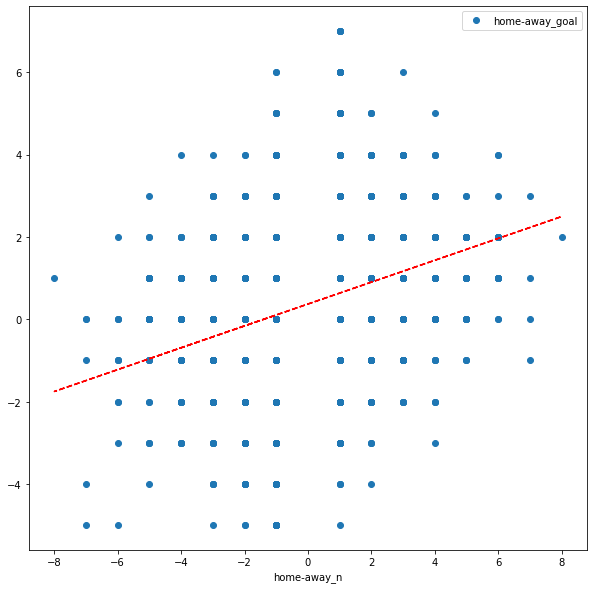

In [ ]:
# Dataframe with no player and beting record
df_allNaN = df_match
for col in home_player_columns+away_player_columns+betting_columns:
  df_allNaN = df_allNaN[df_allNaN[col].isnull()]
  
# Dataframe with no player record but has betting records
df_xbothplayer = df_match
for col in home_player_columns+away_player_columns:
  df_xbothplayer = df_xbothplayer[df_xbothplayer[col].isnull()]
df_xbothplayer = df_xbothplayer.drop(df_allNaN.index)

# Dataframe with no betting record but has home and away player records
df_xbetting = df_match
for col in betting_columns:
  df_xbetting = df_xbetting[df_xbetting[col].isnull()]
df_xbetting = df_xbetting.drop(df_allNaN.index)

# Dataframe differs in Player number 
df_diffnplayer = df_match[home_player_columns].notnull().sum(axis=1).to_frame(name = 'n_homeplayer')
df_diffnplayer['n_awayplayer'] = df_match[away_player_columns].notnull().sum(axis=1)
df_diffnplayer['home_team_goal'] = df_match['home_team_goal']
df_diffnplayer['away_team_goal'] = df_match['away_team_goal']
df_diffnplayer['home-away_n'] = df_diffnplayer['n_homeplayer'] - df_diffnplayer['n_awayplayer']
df_diffnplayer['home-away_goal'] = df_diffnplayer['home_team_goal'] - df_diffnplayer['away_team_goal']
df_diffnplayer = df_diffnplayer[df_diffnplayer['n_homeplayer'] != df_diffnplayer['n_awayplayer']]

# It is "likely" to goal more (= win) if number of players are increasing
# If number of players are same, does not matter of course
df_diffnplayer.plot(x='home-away_n', y='home-away_goal', style='o', figsize = (10,10))
p = np.poly1d(np.polyfit(df_diffnplayer['home-away_n'], df_diffnplayer['home-away_goal'], 1))
plt.plot(df_diffnplayer['home-away_n'],p(df_diffnplayer['home-away_n']),"r--")
df_diffnplayer = df_match.drop(df_match.index ^ df_diffnplayer.index)

In [ ]:
# Dataframe that have at least one bidding and one players each 
df_match_dropped = df_match.drop(df_allNaN.index) #drop all ros are NaN
df_match_dropped = df_match_dropped.drop(df_xbetting.index) #drop if all biddings are NaN
df_match_dropped = df_match_dropped.drop(df_xbothplayer.index) #drop if all players are NaN

# Substitute NaN player as 0, later will create dummy player with id 0 when addting player attribute to match data
# Substitute and NaN bidding as -1, later use if else statement to handle those while prediction
df_match_dropped[home_player_columns+away_player_columns] = df_match_dropped[home_player_columns+away_player_columns].fillna(0)
df_match_dropped[home_player_columns+away_player_columns] = df_match_dropped[home_player_columns+away_player_columns].astype(int)
df_match_dropped[betting_columns] = df_match_dropped[betting_columns].fillna(-1)
df_match_dropped

,country_id,league_id,season,stage,date,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
144,1,1,2008/2009,24,2/28/09 0:00,493016,9996,8635,1,1,39890,0,38788,38312,26235,0,0,0,26916,0,94289,34480,38388,26458,13423,38389,38798,30949,38253,106013,38383,46552,5.75,3.75,1.55,5.50,3.65,1.55,4.80,3.5,1.55,5.00,3.50,1.57,-1.00,-1.00,-1.00,4.80,3.40,1.62,5.50,3.50,1.62,5.00,3.40,1.60,5.25,3.60,1.60,5.50,3.60,1.53
145,1,1,2008/2009,24,2/27/09 0:00,493017,8203,9987,2,1,38327,67950,67958,67959,37112,36393,148286,67898,164352,38801,26502,37937,38293,148313,104411,148314,37202,43158,9307,42153,32690,38782,3.00,3.40,2.30,2.95,3.25,2.20,2.80,3.1,2.20,2.75,3.25,2.20,-1.00,-1.00,-1.00,2.62,3.20,2.30,3.05,3.20,2.30,2.65,3.25,2.35,2.90,3.25,2.30,2.80,3.20,2.25
146,1,1,2008/2009,24,2/28/09 0:00,493018,9986,9998,3,0,95597,0,0,38435,94462,46004,164732,0,38246,38423,38419,38252,39156,39151,166554,15652,39145,46890,38947,46881,39158,119118,2.00,3.40,3.40,1.80,3.35,4.05,1.80,3.2,3.70,1.90,3.20,3.50,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.83,3.40,4.10,1.90,3.25,3.75,1.83,3.25,4.25,1.91,3.25,3.60
147,1,1,2008/2009,24,3/1/09 0:00,493019,9985,9984,4,0,0,39580,30692,37861,47411,119117,35412,39631,39591,25957,38369,36835,37047,37021,38186,27110,32863,37957,37909,104386,38251,37065,1.44,3.75,7.50,1.50,3.55,6.50,1.40,3.9,6.00,1.44,3.60,6.50,-1.00,-1.00,-1.00,1.40,3.75,7.00,1.50,3.75,6.50,1.40,3.75,7.50,1.45,3.75,7.50,1.40,3.75,7.50
148,1,1,2008/2009,24,3/1/09 0:00,493020,9994,9991,0,1,30934,38292,11569,38273,14642,38945,38290,95609,38257,0,121639,104378,27838,36841,38337,0,33662,37044,32760,38229,12574,46335,2.62,3.25,2.45,2.70,3.00,2.50,2.50,3.1,2.40,2.50,3.25,2.37,-1.00,-1.00,-1.00,2.62,3.20,2.30,2.75,3.20,2.50,2.80,3.25,2.30,2.65,3.20,2.50,2.62,3.20,2.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24552,21518,21518,2015/2016,9,10/25/15 0:00,2030167,9906,10267,2,1,177126,38424,474589,56678,41167,33635,30871,184533,354467,51360,184138,489240,361757,184999,361710,391058,75307,40148,570432,361770,193869,428947,1.57,3.80,6.50,1.57,4.00,6.50,1.65,3.7,4.90,1.57,3.75,6.50,1.58,4.05,7.06,1.62,3.30,7.00,-1.00,-1.00,-1.00,1.57,4.00,7.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
24553,21518,21518,2015/2016,9,10/24/15 0:00,2030168,9864,9783,2,0,25563,104382,477471,41707,38842,39198,238841,261599,37450,215927,213653,32678,103905,191906,121872,33848,279173,51953,40668,474680,37653,194660,2.25,3.25,3.40,2.35,3.10,3.10,2.20,3.2,3.20,2.25,3.20,3.25,2.36,3.36,3.36,2.38,3.10,3.10,-1.00,-1.00,-1.00,2.30,3.40,3.40,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
24554,21518,21518,2015/2016,9,10/26/15 0:00,2030169,8315,9869,3,0,33764,181297,159881,411617,154938,182224,33871,45749,604105,96619,33028,102394,150480,384374,150764,239965,359191,202639,242477,541557,395154,206301,1.53,4.00,7.00,1.55,4.00,6.50,1.60,3.7,5.40,1.50,4.00,6.50,1.55,4.31,6.95,1.57,3.50,7.00,-1.00,-1.00,-1.00,1.55,4.20,7.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
24555,21518,21518,2015/2016,9,10/24/15 0:00,2030170,7878,8603,1,1,104986,261609,108572,2752,239350,2805,170667,80492,534484,161291,43372,40648,239964,268273,27461,445907,37824,111801,535600,193226,114746,96652,2.30,3.25,3.25,2.35,3.25,3.00,2.40,3.3,2.75,2.30,3.20,3.10,2.34,3.40,3.35,2.40,3.10,3.10,-1.00,-1.00,-1.00,2.30,3.40,3.30,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00


In [ ]:
#You could see 9 teams in match data does not have team attribute so drop it 
print("Is there's no data with home_team_id: ", set(df_match_dropped.home_team_id.unique()) - set(df_team_attributes.team_id.unique()))
print("Is there's no data with away_team_id: ", set(df_match_dropped.away_team_id.unique()) - set(df_team_attributes.team_id.unique()))


Is there's no data with home_team_id:  {4064, 188163, 9765, 10213, 6601, 7947, 4049, 7992, 6367}
Is there's no data with away_team_id:  {4064, 188163, 10213, 9765, 6601, 7947, 4049, 7992, 6367}


In [ ]:
drop_team_list = list(set(df_match_dropped.home_team_id.unique()) - set(df_team_attributes.team_id.unique()))
print("There's {} rows to drop \nDropping... \nBefore: {}".format(len(df_match_dropped.query("home_team_id in @drop_team_list")),df_match_dropped.shape),end=' ')
df_match_dropped = df_match_dropped.drop(df_match_dropped.query("home_team_id in @drop_team_list").index)
print("After: {}".format(df_match_dropped.shape))

There's 96 rows to drop 
Dropping... 
Before: (22082, 62) After: (21986, 62)


In [ ]:
# Check if player attribute exist in match set - all data presents except dummy data 0
set(np.unique(df_match_dropped[home_player_columns+away_player_columns].values)) - set(df_player_attributes.player_id.unique())

{0}

In [ ]:
df_match_dropped.to_csv(PATH+'df_match_dropped.csv',index=False)

In [ ]:
df_match_dropped

,country_id,league_id,season,stage,date,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,2008/2009,24,2/28/09 0:00,493016,9996,8635,1,1,39890,0,38788,38312,26235,0,0,0,26916,0,94289,34480,38388,26458,13423,38389,38798,30949,38253,106013,38383,46552,5.75,3.75,1.55,5.50,3.65,1.55,4.80,3.5,1.55,5.00,3.50,1.57,-1.00,-1.00,-1.00,4.80,3.40,1.62,5.50,3.50,1.62,5.00,3.40,1.60,5.25,3.60,1.60,5.50,3.60,1.53
1,1,1,2008/2009,24,2/27/09 0:00,493017,8203,9987,2,1,38327,67950,67958,67959,37112,36393,148286,67898,164352,38801,26502,37937,38293,148313,104411,148314,37202,43158,9307,42153,32690,38782,3.00,3.40,2.30,2.95,3.25,2.20,2.80,3.1,2.20,2.75,3.25,2.20,-1.00,-1.00,-1.00,2.62,3.20,2.30,3.05,3.20,2.30,2.65,3.25,2.35,2.90,3.25,2.30,2.80,3.20,2.25
2,1,1,2008/2009,24,2/28/09 0:00,493018,9986,9998,3,0,95597,0,0,38435,94462,46004,164732,0,38246,38423,38419,38252,39156,39151,166554,15652,39145,46890,38947,46881,39158,119118,2.00,3.40,3.40,1.80,3.35,4.05,1.80,3.2,3.70,1.90,3.20,3.50,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.83,3.40,4.10,1.90,3.25,3.75,1.83,3.25,4.25,1.91,3.25,3.60
3,1,1,2008/2009,24,3/1/09 0:00,493019,9985,9984,4,0,0,39580,30692,37861,47411,119117,35412,39631,39591,25957,38369,36835,37047,37021,38186,27110,32863,37957,37909,104386,38251,37065,1.44,3.75,7.50,1.50,3.55,6.50,1.40,3.9,6.00,1.44,3.60,6.50,-1.00,-1.00,-1.00,1.40,3.75,7.00,1.50,3.75,6.50,1.40,3.75,7.50,1.45,3.75,7.50,1.40,3.75,7.50
4,1,1,2008/2009,24,3/1/09 0:00,493020,9994,9991,0,1,30934,38292,11569,38273,14642,38945,38290,95609,38257,0,121639,104378,27838,36841,38337,0,33662,37044,32760,38229,12574,46335,2.62,3.25,2.45,2.70,3.00,2.50,2.50,3.1,2.40,2.50,3.25,2.37,-1.00,-1.00,-1.00,2.62,3.20,2.30,2.75,3.20,2.50,2.80,3.25,2.30,2.65,3.20,2.50,2.62,3.20,2.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21981,21518,21518,2015/2016,9,10/25/15 0:00,2030167,9906,10267,2,1,177126,38424,474589,56678,41167,33635,30871,184533,354467,51360,184138,489240,361757,184999,361710,391058,75307,40148,570432,361770,193869,428947,1.57,3.80,6.50,1.57,4.00,6.50,1.65,3.7,4.90,1.57,3.75,6.50,1.58,4.05,7.06,1.62,3.30,7.00,-1.00,-1.00,-1.00,1.57,4.00,7.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
21982,21518,21518,2015/2016,9,10/24/15 0:00,2030168,9864,9783,2,0,25563,104382,477471,41707,38842,39198,238841,261599,37450,215927,213653,32678,103905,191906,121872,33848,279173,51953,40668,474680,37653,194660,2.25,3.25,3.40,2.35,3.10,3.10,2.20,3.2,3.20,2.25,3.20,3.25,2.36,3.36,3.36,2.38,3.10,3.10,-1.00,-1.00,-1.00,2.30,3.40,3.40,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
21983,21518,21518,2015/2016,9,10/26/15 0:00,2030169,8315,9869,3,0,33764,181297,159881,411617,154938,182224,33871,45749,604105,96619,33028,102394,150480,384374,150764,239965,359191,202639,242477,541557,395154,206301,1.53,4.00,7.00,1.55,4.00,6.50,1.60,3.7,5.40,1.50,4.00,6.50,1.55,4.31,6.95,1.57,3.50,7.00,-1.00,-1.00,-1.00,1.55,4.20,7.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
21984,21518,21518,2015/2016,9,10/24/15 0:00,2030170,7878,8603,1,1,104986,261609,108572,2752,239350,2805,170667,80492,534484,161291,43372,40648,239964,268273,27461,445907,37824,111801,535600,193226,114746,96652,2.30,3.25,3.25,2.35,3.25,3.00,2.40,3.3,2.75,2.30,3.20,3.10,2.34,3.40,3.35,2.40,3.10,3.10,-1.00,-1.00,-1.00,2.30,3.40,3.30,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00


# Merge

In [ ]:
#Ready to go Merge player attribute and team attribute
#Match   player_att   team_att
# 62  +   46*(11*2)  +  2*23 = 1120 column 

In [ ]:
df_match_dropped['yr'] = df_match_dropped.date.str.split('/').str[2].str.split(' ').str[0].astype(int)
df_match_dropped['month'] = df_match_dropped.date.str.split('/').str[0].astype(int)
df_match_dropped

,country_id,league_id,season,stage,date,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,yr,month
144,1,1,2008/2009,24,2/28/09 0:00,493016,9996,8635,1,1,39890,0,38788,38312,26235,0,0,0,26916,0,94289,34480,38388,26458,13423,38389,38798,30949,38253,106013,38383,46552,5.75,3.75,1.55,5.50,3.65,1.55,4.80,3.5,1.55,5.00,3.50,1.57,-1.00,-1.00,-1.00,4.80,3.40,1.62,5.50,3.50,1.62,5.00,3.40,1.60,5.25,3.60,1.60,5.50,3.60,1.53,9,2
145,1,1,2008/2009,24,2/27/09 0:00,493017,8203,9987,2,1,38327,67950,67958,67959,37112,36393,148286,67898,164352,38801,26502,37937,38293,148313,104411,148314,37202,43158,9307,42153,32690,38782,3.00,3.40,2.30,2.95,3.25,2.20,2.80,3.1,2.20,2.75,3.25,2.20,-1.00,-1.00,-1.00,2.62,3.20,2.30,3.05,3.20,2.30,2.65,3.25,2.35,2.90,3.25,2.30,2.80,3.20,2.25,9,2
146,1,1,2008/2009,24,2/28/09 0:00,493018,9986,9998,3,0,95597,0,0,38435,94462,46004,164732,0,38246,38423,38419,38252,39156,39151,166554,15652,39145,46890,38947,46881,39158,119118,2.00,3.40,3.40,1.80,3.35,4.05,1.80,3.2,3.70,1.90,3.20,3.50,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.83,3.40,4.10,1.90,3.25,3.75,1.83,3.25,4.25,1.91,3.25,3.60,9,2
147,1,1,2008/2009,24,3/1/09 0:00,493019,9985,9984,4,0,0,39580,30692,37861,47411,119117,35412,39631,39591,25957,38369,36835,37047,37021,38186,27110,32863,37957,37909,104386,38251,37065,1.44,3.75,7.50,1.50,3.55,6.50,1.40,3.9,6.00,1.44,3.60,6.50,-1.00,-1.00,-1.00,1.40,3.75,7.00,1.50,3.75,6.50,1.40,3.75,7.50,1.45,3.75,7.50,1.40,3.75,7.50,9,3
148,1,1,2008/2009,24,3/1/09 0:00,493020,9994,9991,0,1,30934,38292,11569,38273,14642,38945,38290,95609,38257,0,121639,104378,27838,36841,38337,0,33662,37044,32760,38229,12574,46335,2.62,3.25,2.45,2.70,3.00,2.50,2.50,3.1,2.40,2.50,3.25,2.37,-1.00,-1.00,-1.00,2.62,3.20,2.30,2.75,3.20,2.50,2.80,3.25,2.30,2.65,3.20,2.50,2.62,3.20,2.38,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24552,21518,21518,2015/2016,9,10/25/15 0:00,2030167,9906,10267,2,1,177126,38424,474589,56678,41167,33635,30871,184533,354467,51360,184138,489240,361757,184999,361710,391058,75307,40148,570432,361770,193869,428947,1.57,3.80,6.50,1.57,4.00,6.50,1.65,3.7,4.90,1.57,3.75,6.50,1.58,4.05,7.06,1.62,3.30,7.00,-1.00,-1.00,-1.00,1.57,4.00,7.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,15,10
24553,21518,21518,2015/2016,9,10/24/15 0:00,2030168,9864,9783,2,0,25563,104382,477471,41707,38842,39198,238841,261599,37450,215927,213653,32678,103905,191906,121872,33848,279173,51953,40668,474680,37653,194660,2.25,3.25,3.40,2.35,3.10,3.10,2.20,3.2,3.20,2.25,3.20,3.25,2.36,3.36,3.36,2.38,3.10,3.10,-1.00,-1.00,-1.00,2.30,3.40,3.40,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,15,10
24554,21518,21518,2015/2016,9,10/26/15 0:00,2030169,8315,9869,3,0,33764,181297,159881,411617,154938,182224,33871,45749,604105,96619,33028,102394,150480,384374,150764,239965,359191,202639,242477,541557,395154,206301,1.53,4.00,7.00,1.55,4.00,6.50,1.60,3.7,5.40,1.50,4.00,6.50,1.55,4.31,6.95,1.57,3.50,7.00,-1.00,-1.00,-1.00,1.55,4.20,7.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,15,10
24555,21518,21518,2015/2016,9,10/24/15 0:00,2030170,7878,8603,1,1,104986,261609,108572,2752,239350,2805,170667,80492,534484,161291,43372,40648,239964,268273,27461,445907,37824,111801,535600,193226,114746,96652,2.30,3.25,3.25,2.35,3.25,3.00,2.40,3.3,2.75,2.30,3.20,3.10,2.34,3.40,3.35,2.40,3.10,3.10,-1.00,-1.00,-1.00,2.30,3.40,3.30,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,15,10


In [ ]:
df_match_dropped

## Team player attribute preprocessing to make year feature for inner merge



In [ ]:
df_team = pd.merge(df_team, df_team_attributes, on='team_id')
df_team['yr'] = df_team.date.str.split('/').str[2].str.split(' ').str[0].astype(int)
df_team

,team_id,team_long_name,team_short_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,9987,KRC Genk,GEN,2/22/10 0:00,45,Balanced,NaN,Little,45,Mixed,Organised,50,Normal,35,Normal,60,Normal,Organised,70,High,65,Press,70,Wide,Cover
1,9987,KRC Genk,GEN,2/22/11 0:00,66,Balanced,NaN,Little,52,Mixed,Organised,65,Normal,66,Normal,51,Normal,Organised,48,Medium,47,Press,54,Normal,Offside Trap
2,9987,KRC Genk,GEN,2/22/12 0:00,53,Balanced,NaN,Little,55,Mixed,Organised,55,Normal,48,Normal,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
3,9987,KRC Genk,GEN,9/20/13 0:00,58,Balanced,NaN,Little,38,Mixed,Organised,67,Risky,48,Normal,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
4,9987,KRC Genk,GEN,9/19/14 0:00,58,Balanced,52.0,Normal,38,Mixed,Organised,67,Risky,48,Normal,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,9777,Servette FC,SER,9/20/13 0:00,48,Balanced,NaN,Little,51,Mixed,Organised,53,Normal,66,Normal,45,Normal,Organised,49,Medium,45,Press,49,Normal,Cover
1454,7730,FC Lausanne-Sports,LAU,2/22/10 0:00,30,Slow,NaN,Little,60,Mixed,Organised,40,Normal,60,Normal,60,Normal,Organised,55,Medium,60,Press,50,Normal,Cover
1455,7730,FC Lausanne-Sports,LAU,2/22/12 0:00,37,Balanced,NaN,Little,49,Mixed,Organised,52,Normal,60,Normal,48,Normal,Organised,43,Medium,43,Press,55,Normal,Cover
1456,7730,FC Lausanne-Sports,LAU,9/20/13 0:00,51,Balanced,NaN,Little,49,Mixed,Organised,52,Normal,60,Normal,48,Normal,Organised,43,Medium,43,Press,55,Normal,Cover


In [ ]:
df_team

,team_id,team_long_name,team_short_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,yr
0,9987,KRC Genk,GEN,2/22/10 0:00,45,Balanced,NaN,Little,45,Mixed,Organised,50,Normal,35,Normal,60,Normal,Organised,70,High,65,Press,70,Wide,Cover,10
1,9987,KRC Genk,GEN,2/22/11 0:00,66,Balanced,NaN,Little,52,Mixed,Organised,65,Normal,66,Normal,51,Normal,Organised,48,Medium,47,Press,54,Normal,Offside Trap,11
2,9987,KRC Genk,GEN,2/22/12 0:00,53,Balanced,NaN,Little,55,Mixed,Organised,55,Normal,48,Normal,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover,12
3,9987,KRC Genk,GEN,9/20/13 0:00,58,Balanced,NaN,Little,38,Mixed,Organised,67,Risky,48,Normal,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover,13
4,9987,KRC Genk,GEN,9/19/14 0:00,58,Balanced,52.0,Normal,38,Mixed,Organised,67,Risky,48,Normal,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,9777,Servette FC,SER,9/20/13 0:00,48,Balanced,NaN,Little,51,Mixed,Organised,53,Normal,66,Normal,45,Normal,Organised,49,Medium,45,Press,49,Normal,Cover,13
1454,7730,FC Lausanne-Sports,LAU,2/22/10 0:00,30,Slow,NaN,Little,60,Mixed,Organised,40,Normal,60,Normal,60,Normal,Organised,55,Medium,60,Press,50,Normal,Cover,10
1455,7730,FC Lausanne-Sports,LAU,2/22/12 0:00,37,Balanced,NaN,Little,49,Mixed,Organised,52,Normal,60,Normal,48,Normal,Organised,43,Medium,43,Press,55,Normal,Cover,12
1456,7730,FC Lausanne-Sports,LAU,9/20/13 0:00,51,Balanced,NaN,Little,49,Mixed,Organised,52,Normal,60,Normal,48,Normal,Organised,43,Medium,43,Press,55,Normal,Cover,13


In [ ]:
# You can see 21986 - 16740 = 5246 match data has no team attribute on that season
dff = pd.merge(df_match_dropped, df_team, left_on=["home_team_id","yr"], right_on=["team_id","yr"], how='inner')
dff

,country_id,league_id,season,stage,date_x,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,...,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,yr,month,team_id,team_long_name,team_short_name,date_y,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,1,2009/2010,19,2/3/10 0:00,665626,8635,8342,3,2,38391,33620,38388,38389,38253,69713,38393,148302,38378,38383,181276,37990,36832,21812,38336,39578,37979,11736,42594,38366,163670,75405,1.73,3.60,4.75,1.75,3.40,4.25,1.75,3.3,...,5.00,1.75,3.6,4.75,1.67,3.6,4.50,1.72,3.40,4.5,1.73,3.4,4.2,10,2,8635,RSC Anderlecht,AND,2/22/10 0:00,50,Balanced,NaN,Little,35,Mixed,Organised,70,Risky,50,Normal,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
1,1,1,2009/2010,25,2/6/10 0:00,665698,8635,9997,1,2,38391,33620,38389,38393,69713,38383,38253,148302,25499,46552,12692,37868,33595,3329,178486,149150,38354,37866,36836,68120,5016,45490,1.22,5.75,13.00,1.20,5.60,11.00,1.20,5.0,...,11.00,1.22,6.0,13.00,1.20,5.5,12.00,1.25,5.50,8.5,1.22,5.0,11.0,10,2,8635,RSC Anderlecht,AND,2/22/10 0:00,50,Balanced,NaN,Little,35,Mixed,Organised,70,Risky,50,Normal,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
2,1,1,2009/2010,27,2/21/10 0:00,665729,8635,8203,2,0,38391,38388,38389,38253,69713,38798,38383,38393,148302,37069,46552,38327,6800,39389,67941,67959,67898,38969,178291,38799,148286,17276,1.25,5.25,13.00,1.20,5.60,11.00,1.22,4.8,...,10.00,1.22,6.5,12.00,1.22,5.0,13.00,1.22,5.50,10.0,1.20,5.5,11.0,10,2,8635,RSC Anderlecht,AND,2/22/10 0:00,50,Balanced,NaN,Little,35,Mixed,Organised,70,Risky,50,Normal,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
3,1,1,2009/2010,29,3/14/10 0:00,665745,8635,9987,2,0,38391,38388,38389,69713,38378,38383,38393,38253,148302,46552,181276,91929,38785,104411,148314,178276,32863,39498,43158,42153,38794,169200,1.40,4.50,8.00,1.35,4.40,7.50,1.40,3.9,...,8.50,1.36,4.5,8.50,1.40,4.0,7.50,1.38,4.25,7.0,1.40,4.0,7.5,10,3,8635,RSC Anderlecht,AND,2/22/10 0:00,50,Balanced,NaN,Little,35,Mixed,Organised,70,Risky,50,Normal,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
4,1,1,2010/2011,1,7/31/10 0:00,838473,8635,6351,4,1,38391,38388,38389,69713,38378,38383,38393,38253,148302,37069,46552,67949,45413,181051,7683,150396,25751,118666,181054,6771,39312,5468,1.20,6.50,10.00,1.20,5.60,11.00,1.20,5.0,...,13.00,1.20,6.5,13.00,1.17,5.5,13.00,1.20,6.00,10.0,1.17,6.0,13.0,10,7,8635,RSC Anderlecht,AND,2/22/10 0:00,50,Balanced,NaN,Little,35,Mixed,Organised,70,Risky,50,Normal,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16465,21518,21518,2015/2016,2,8/30/15 0:00,2030093,8306,8581,0,0,71498,358339,11736,74989,291635,183497,213729,243781,292262,0,190669,37656,287691,280485,282473,37484,184091,364244,38469,513086,301809,476769,1.91,3.30,4.50,1.91,3.25,4.20,2.00,3.3,...,4.50,-1.00,-1.0,-1.00,1.93,3.4,4.75,-1.00,-1.00,-1.0,-1.00,-1.0,-1.0,15,8,8306,UD Las Palmas,LAS,9/10/15 0:00,48,Balanced,55.0,Norm

In [ ]:
dff.to_csv(PATH+'df_match_dropped_noteamattribute_inner_by_year.csv', index = False)

In [ ]:
# For example, 9996 team_id should have data in 2009 but only 2015 data is available
df_team[df_team.team_id == 9996]

,team_id,team_long_name,team_short_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,yr
68,9996,Royal Excel Mouscron,MOU,9/10/15 0:00,50,Balanced,50.0,Normal,50,Mixed,Organised,50,Normal,50,Normal,50,Normal,Organised,45,Medium,45,Press,50,Normal,Cover,15
69,9996,Royal Excel Mouscron,MOU,9/10/15 0:00,50,Balanced,50.0,Normal,50,Mixed,Organised,50,Normal,50,Normal,50,Normal,Organised,45,Medium,45,Press,50,Normal,Cover,15


# Duplicated Data

In [ ]:
df_team[df_team.duplicated(keep=False)]

,team_id,team_long_name,team_short_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,yr
68,9996,Royal Excel Mouscron,MOU,9/10/15 0:00,50,Balanced,50.0,Normal,50,Mixed,Organised,50,Normal,50,Normal,50,Normal,Organised,45,Medium,45,Press,50,Normal,Cover,15
69,9996,Royal Excel Mouscron,MOU,9/10/15 0:00,50,Balanced,50.0,Normal,50,Mixed,Organised,50,Normal,50,Normal,50,Normal,Organised,45,Medium,45,Press,50,Normal,Cover,15


In [ ]:
df_player[df_player.duplicated(keep=False)]

,player_id,player_name,birthday,height,weight,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,yr,season,month,age
84716,32968,John Potter,12/15/79 0:00,185.42,183,2/22/07 0:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,2006/2007,2,28
84717,32968,John Potter,12/15/79 0:00,185.42,183,2/22/07 0:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,2006/2007,2,28


In [ ]:
df_match_dropped[df_match_dropped.duplicated(keep=False)]

,country_id,league_id,season,stage,date,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,yr,month


## player attribute preprocessing to make season feature for inner merge

In [ ]:
print("is player_id all present: ", set(df_player.player_id.unique()) == set(df_player_attributes.player_id.unique()))
df_player = pd.merge(df_player, df_player_attributes, on='player_id')
print(len(df_player)==len(df_player_attributes))

(1458, 23)

In [ ]:
# date -> yr and month
# yr - birthday -> age
df_player['yr'] = df_player.date.str.split('/').str[2].str.split(' ').str[0].astype(int)
df_player['month'] = df_player.date.str.split('/').str[0].astype(int)
df_player['age'] = (2000+df_player['yr']) - (1900+df_player.birthday.str.split('/').str[2].str.split(' ').str[0].astype(int))
df_player


In [ ]:
df_match.season.unique()

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2013/2014', '2014/2015', '2015/2016'], dtype=object)

In [ ]:
from tqdm import tqdm

# yr and month -> season
yr_mth = df_player[['yr','month']].values
season = np.array(range(183978), dtype=str).reshape(183978,1)

i = 0
for yr, mth in tqdm(yr_mth):
    if yr == 7 and mth > 6: season[i] = '2006/2007'
    elif (yr == 7 and mth <= 6) or (yr == 8 and mth > 6): season[i] = '2007/2008'
    elif (yr == 8 and mth <= 6) or (yr == 9 and mth > 6): season[i] = '2008/2009'
    elif (yr == 9 and mth <= 6) or (yr == 10 and mth > 6): season[i] = '2009/20010'
    elif (yr == 10 and mth <= 6) or (yr == 11 and mth > 6): season[i] = '2010/2011'
    elif (yr == 11 and mth <= 6) or (yr == 12 and mth > 6): season[i] = '2011/2012'
    elif (yr == 12 and mth <= 6) or (yr == 13 and mth > 6): season[i] = '2012/2013'
    elif (yr == 13 and mth <= 6) or (yr == 14 and mth > 6): season[i] = '2013/2014'
    elif (yr == 14 and mth <= 6) or (yr == 15 and mth > 6): season[i] = '2014/2015'
    elif (yr == 15 and mth <= 16) or (yr == 16 and mth > 6): season[i] = '2015/2016'
    else:
      i+=1
      continue
    i+=1
season 

# or better use pd.datetime.to_period("Q")

100%|██████████| 183978/183978 [00:01<00:00, 161186.72it/s]


array([['0'],
       ['2014/2'],
       ['2014/2'],
       ...,
       ['2007/2'],
       ['2006/2'],
       ['2007/2']], dtype='<U6')

In [ ]:
#dff = pd.merge(df_match_dropped, df_player, left_on=["home_player_1","season"], right_on=["player_id","season"], how='inner')
#dff